## 12.2 特征提取
	在特征提取中，可以在预先训练好的网络结构后修改或添加一个简单的分类器，将源任务上预先训练好的网络作为另一个目标任务的特征提取器，只对最后增加的分类器参数进行重新学习，而不修改或冻结预先训练好的网络参数。这样新任务在特征提取时使用的是源任务中学习到的参数，而不用重新学习所有参数。特征提取过程如图12-2所示。
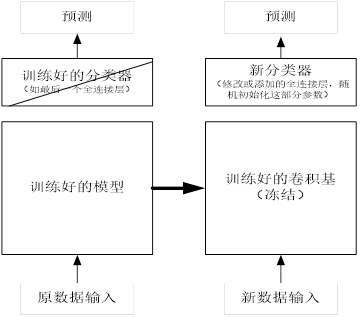
<center>图12-2 特征提取方法示意图</center>
	PyTorch如何实现冻结网络部分层？本节后续将介绍。

### 12.2.1 PyTorch提供的预处理模块

### 12.2.2 特征提取实例
	下面用一个实例具体说明如何通过特征提取的方法进行图像分类。在6.5节我们在CIFAR-10数据集上构建一个神经网络，对数据集中的10类物体进行分类，使用了几层卷积层和全连接层，准确率在68%左右，这个精度显然不尽如人意。本节将使用迁移学习中的特征提取方法来实现这个任务，预训练模型采用RetNet 18网络，精度可提升到75%左右。以下是具体代码实现过程。代码清单为pytorch-12-01。
1.导入模块

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

2.加载数据  
    这里的数据加载也与6.5节的基本相同，为适合预训练模型，增加了一些预处理功能，如数据标准化、对图像进行裁剪等。

In [4]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),     
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


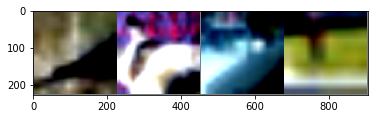

 bird   cat   car horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 显示图像
imshow(torchvision.utils.make_grid(images[:4]))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

3.下载预训练模型  
 自动下载预训练模型，该模型网络架构为ResNet 18，已经在ImageNet大数据集上训练好了，该数据集有1000个类别。

In [6]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)

4.冻结模型参数  
    参数被冻结后，在反向传播时，将不会更新。


In [7]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

5.修改最后一层的输出类别数  
    原来输出为512x1000，我们把输出改为512x10，新的数据集有10个类别。


In [11]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
#net = torch.nn.DataParallel(net)

6.查看冻结前后的参数情况

In [12]:
# 查看总参数及训练参数
total_params = sum(p.numel() for p in net.parameters())
print('总参数个数:{}'.format(total_params))
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('需训练参数个数:{}'.format(total_trainable_params))


总参数个数:11181642
需训练参数个数:5130


In [13]:
net=net.to(device)

In [14]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


7.定义损失函数及优化器  
具体实现代码如下：

In [15]:
criterion = nn.CrossEntropyLoss()
#只需要优化最后一层参数
optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)


In [16]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
   
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

8.训练及验证模型  
训练及验证模型代码如下。

In [17]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.465341, Train Acc: 0.499201, Valid Loss: 0.917795, Valid Acc: 0.699244, Time 00:00:54
Epoch 1. Train Loss: 1.215002, Train Acc: 0.582421, Valid Loss: 0.813977, Valid Acc: 0.731887, Time 00:01:04
Epoch 2. Train Loss: 1.182016, Train Acc: 0.589134, Valid Loss: 0.782587, Valid Acc: 0.738854, Time 00:01:04
Epoch 3. Train Loss: 1.157905, Train Acc: 0.594849, Valid Loss: 0.767151, Valid Acc: 0.741441, Time 00:01:05
Epoch 4. Train Loss: 1.138812, Train Acc: 0.602242, Valid Loss: 0.749511, Valid Acc: 0.744427, Time 00:01:05
Epoch 5. Train Loss: 1.132890, Train Acc: 0.604040, Valid Loss: 0.749692, Valid Acc: 0.743730, Time 00:01:05
Epoch 6. Train Loss: 1.130340, Train Acc: 0.603960, Valid Loss: 0.741945, Valid Acc: 0.746218, Time 00:01:06
Epoch 7. Train Loss: 1.117889, Train Acc: 0.608236, Valid Loss: 0.745144, Valid Acc: 0.743631, Time 00:01:06
Epoch 8. Train Loss: 1.115167, Train Acc: 0.609795, Valid Loss: 0.731183, Valid Acc: 0.752289, Time 00:01:07
Epoch 9. Train Loss

与前一个场景相比，这将花费大约一半的时间。这是预期的，因为不需要为大多数网络计算梯度。但是，前向传递需要计算梯度。

## 12.3 数据增强
	提高模型泛化能力的最重要的三大因素是数据、模型、损失函数，其中数据又是三个因素中最重要的因素，但数据的获取往往不充分或成本比较高。是否有其他方法可以快速又便捷地增加数据量呢？在一些领域是存在的，如在图像识别、语言识别领域，可以通过水平或垂直翻转图像、裁剪、色彩变换、扩展和旋转等数据增强（Data Augmentation）技术来增加数据量。
	通过数据增强技术不仅可以扩大训练数据集的规模、降低模型对某些属性的依赖，从而提高模型的泛化能力，也可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性，还可以通过调整亮度、色彩等因素来降低模型对色彩的敏感度等。当然，对图像做这些预处理时，不宜使用会改变其类别的转换，如对于手写的数字，如果旋转90度，就有可能把9变成6，或把6变为9。
此外，把随机噪声添加到输入数据或隐藏单元中也是增加数据量的方法之一。

### 12.3.1 按比例缩放
	随机比例缩放主要使用的是 torchvision.transforms.Resize()函数。

In [18]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

1）显示原图。

(600, 600, 3)

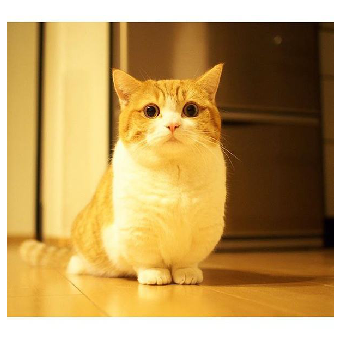

In [19]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open('./image/cat/cat.jpg')
np.array(x).shape
imshow(x)

In [20]:
def imshow_tensor(image, ax=None, title=None):
    """可视化张量(Tensor)"""

    if ax is None:
        fig, ax = plt.subplots()

    # 把第3个维度设置为颜色通道
    image = image.numpy().transpose((1, 2, 0))

    # 反转预处理步骤
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # 剪切图像像素值
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [21]:
import sys

from PIL import Image
from torchvision import transforms as trans

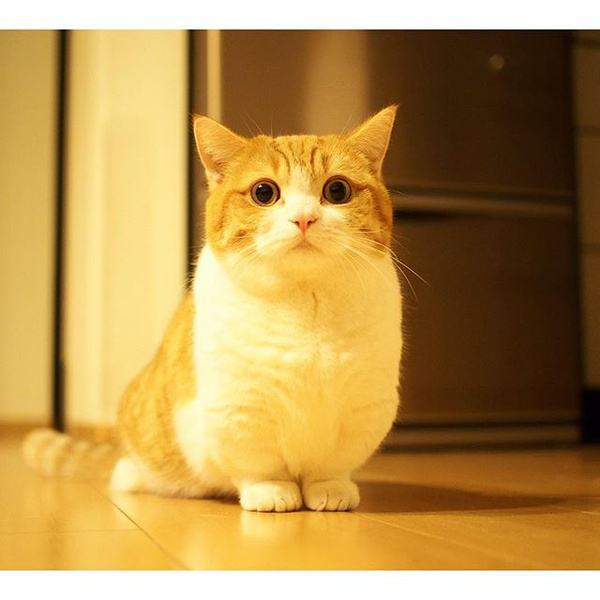

In [22]:
# 读入一张图片
im = Image.open('./image/cat/cat.jpg')
im

2）随机比例缩放。

原图片大小: (600, 600)
缩放后大小: (200, 100)


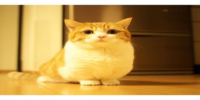

In [23]:
#随机比例缩放主要使用的是 torchvision.transforms.Resize()
# 比例缩放
print('原图片大小: {}'.format(im.size))
new_im = trans.Resize((100, 200))(im)
print('缩放后大小: {}'.format(new_im.size))
new_im


### 12.3.2 裁剪
	随机裁剪有两种方式，一种是对图像在随机位置进行截取，可传入裁剪大小，使用的函数为torchvision.transforms.RandomCrop()；另一种是在中心，按比例裁剪，函数为 torchvision.transforms.CenterCrop()。

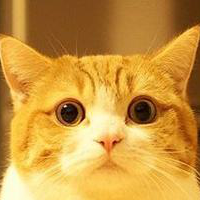

In [24]:
#随机位置截取能够提取出图片中局部的信息，使得网络接受的输入具有多尺度的特征，所以能够有较好的效果。
#在 torchvision 中主要有下面两种方式，一个是 torchvision.transforms.RandomCrop()，
#传入的参数就是截取出的图片的长和宽，对图片在随机位置进行截取；第二个是 torchvision.transforms.CenterCrop()，
#同样传入介曲初的图片的大小作为参数，会在图片的中心进行截取
# 随机裁剪出 100 x 100 的区域
random_im1 = trans.RandomCrop(200)(im)
random_im1

### 12.3.3 翻转
	翻转猫还是猫，不会改变其类别。通过翻转图像可以增加其多样性，所以随机翻转也是一种非常有效的手段。在 torchvision 中，随机翻转使用的是 torchvision.transforms.RandomHorizontalFlip() 、torchvision.transforms.RandomVerticalFlip()和 torchvision.transforms.RandomRotation()等函数。

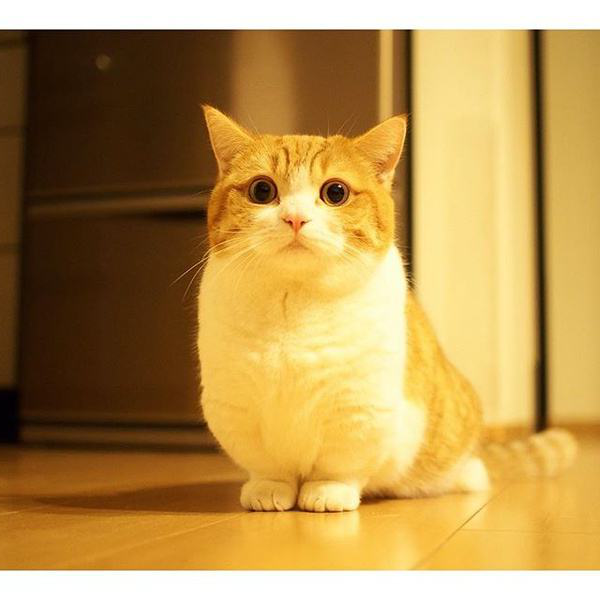

In [25]:
#我们将它翻转一下，它仍然是一张猫，但是图片就有了更多的多样性，所以随机翻转也是一种非常有效的手段。
#在 torchvision 中，随机翻转使用的是 torchvision.transforms.RandomHorizontalFlip() 
#和 torchvision.transforms.RandomVerticalFlip()
# 随机水平翻转
h_filp = trans.RandomHorizontalFlip()(im)
h_filp


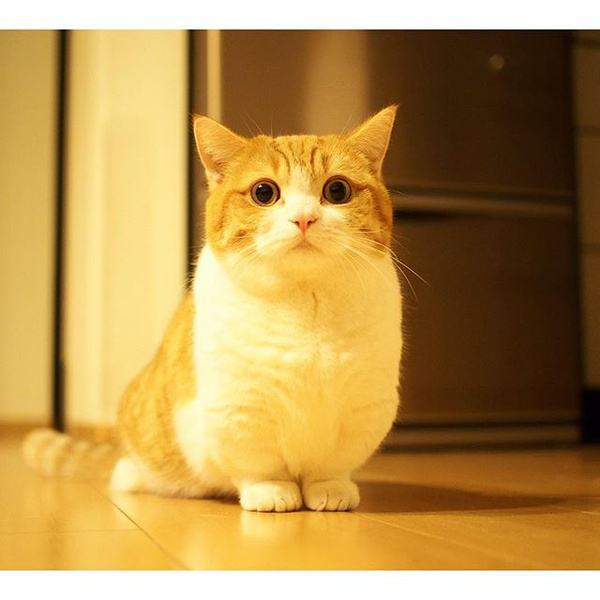

In [26]:
# 随机竖直翻转
v_flip = trans.RandomVerticalFlip()(im)
v_flip

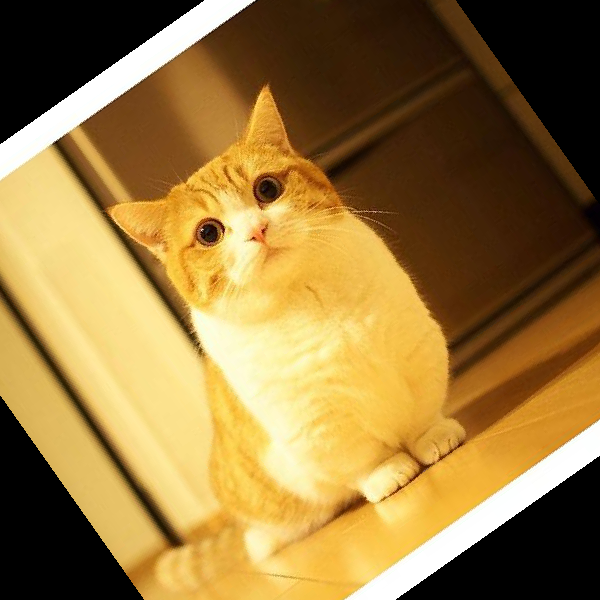

In [28]:
#一些角度的旋转仍然是非常有用的数据增强方式，在 torchvision 中，
#使用 torchvision.transforms.RandomRotation() 来实现
import torchvision.transforms as tfs

rot_im = tfs.RandomRotation(45)(im)
rot_im

### 12.3.4改变颜色
	除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，在 torchvision 中主要是用 torchvision.transforms.ColorJitter() 来实现的。

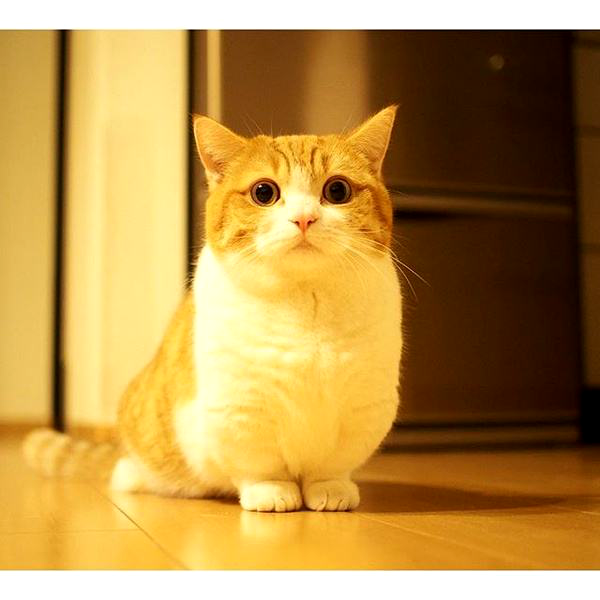

In [29]:
#除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，
#在 torchvision 中主要使用 torchvision.transforms.ColorJitter() 来实现的，第一个参数就是亮度的比例，
#第二个是对比度，第三个是饱和度，第四个是颜色
# 对比度
contrast_im = tfs.ColorJitter(contrast=1)(im) # 随机从 0 ~ 2 之间对比度变化，1 表示原图
contrast_im


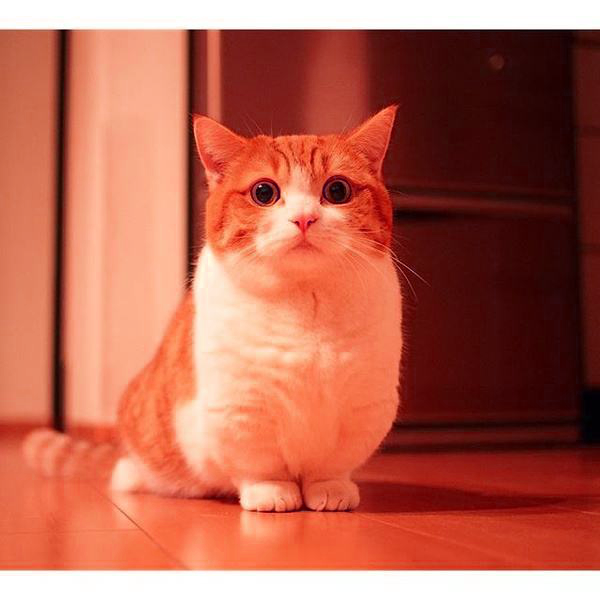

In [30]:
# 颜色
color_im = trans.ColorJitter(hue=0.5)(im) # 随机从 -0.5 ~ 0.5 之间对颜色变化
color_im

### 12.3.5组合多种增强方法
	我们可用torchvision.transforms.Compose() 函数把以上这些变化组合在一起。

In [31]:
im_aug = trans.Compose([
    tfs.Resize(200),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(96),
    tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5)
])


(0.0, 1.0, 0.0, 1.0)

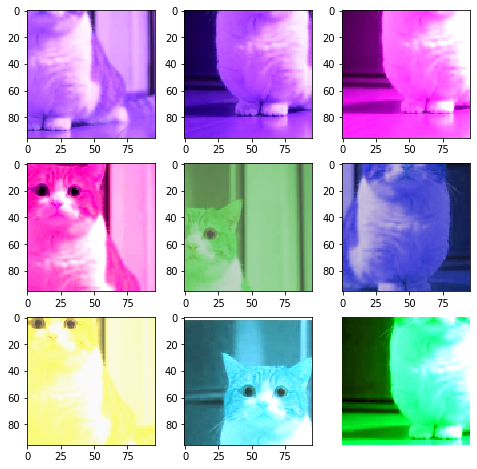

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
plt.axis('off')
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(im_aug(im))
plt.show()
